In [57]:
import os
import cv2
import torch
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt

from cv2 import Mat
from glob import glob
from kornia_moons.viz import draw_LAF_matches


In [58]:
device = torch.device('cuda')
matcher = KF.LoFTR()
matcher = matcher.to(device).eval()

In [59]:
def get_tensor_from_np(img: Mat, device, re_scale=840) -> (torch.Tensor, float, float):
    """ given image and rescale, calculates scale factor. resizing and converting to tensor.
    returns the tensor together with the scales to transpose back to original scale. """
    scale = re_scale / max(img.shape[0], img.shape[1])
    h = int(img.shape[0] * scale)
    w = int(img.shape[1] * scale)
    scale_h = h / img.shape[0]
    scale_w = w / img.shape[1]
    img = cv2.resize(img, (w, h))
    img = K.image_to_tensor(img, keepdim=False).float() / 255
    # cv2 imread, converted image to BGR. here we transform to RGB.
    # img = K.color.bgr_to_rgb(img)
    return img.to(device), scale_h, scale_w


def get_loftr_matches(img1, img2, matcher):
    """ Given img1, img2 and matcher (which is LoFTR torch.model)
    returns the matching key points 0, 1, and confidence by LoFTR. """
    input_dict = {
        "image0": K.color.rgb_to_grayscale(img1),
        "image1": K.color.rgb_to_grayscale(img2),
    }
    with torch.no_grad():
        correspondences = matcher(input_dict)

    mkpts0 = correspondences['keypoints0']
    mkpts1 = correspondences['keypoints1']
    conf = correspondences['confidence']

    return mkpts0, mkpts1, conf

In [60]:
data_src = '../data/cv-22928-2025-a-project/train'

val_scenes = []
for f in os.scandir(data_src):
    if f.is_dir():
        cur_scene = os.path.split(f)[-1]
        print(f'Found scene "{cur_scene}"" at {f.path}')
        val_scenes += [cur_scene]

Found scene "brandenburg_gate"" at ../data/cv-22928-2025-a-project/train\brandenburg_gate
Found scene "british_museum"" at ../data/cv-22928-2025-a-project/train\british_museum
Found scene "buckingham_palace"" at ../data/cv-22928-2025-a-project/train\buckingham_palace
Found scene "colosseum_exterior"" at ../data/cv-22928-2025-a-project/train\colosseum_exterior
Found scene "lincoln_memorial_statue"" at ../data/cv-22928-2025-a-project/train\lincoln_memorial_statue
Found scene "notre_dame_front_facade"" at ../data/cv-22928-2025-a-project/train\notre_dame_front_facade
Found scene "pantheon_exterior"" at ../data/cv-22928-2025-a-project/train\pantheon_exterior
Found scene "sacre_coeur"" at ../data/cv-22928-2025-a-project/train\sacre_coeur
Found scene "sagrada_familia"" at ../data/cv-22928-2025-a-project/train\sagrada_familia
Found scene "taj_mahal"" at ../data/cv-22928-2025-a-project/train\taj_mahal
Found scene "temple_nara_japan"" at ../data/cv-22928-2025-a-project/train\temple_nara_japan
Fo

Loaded 43 images.


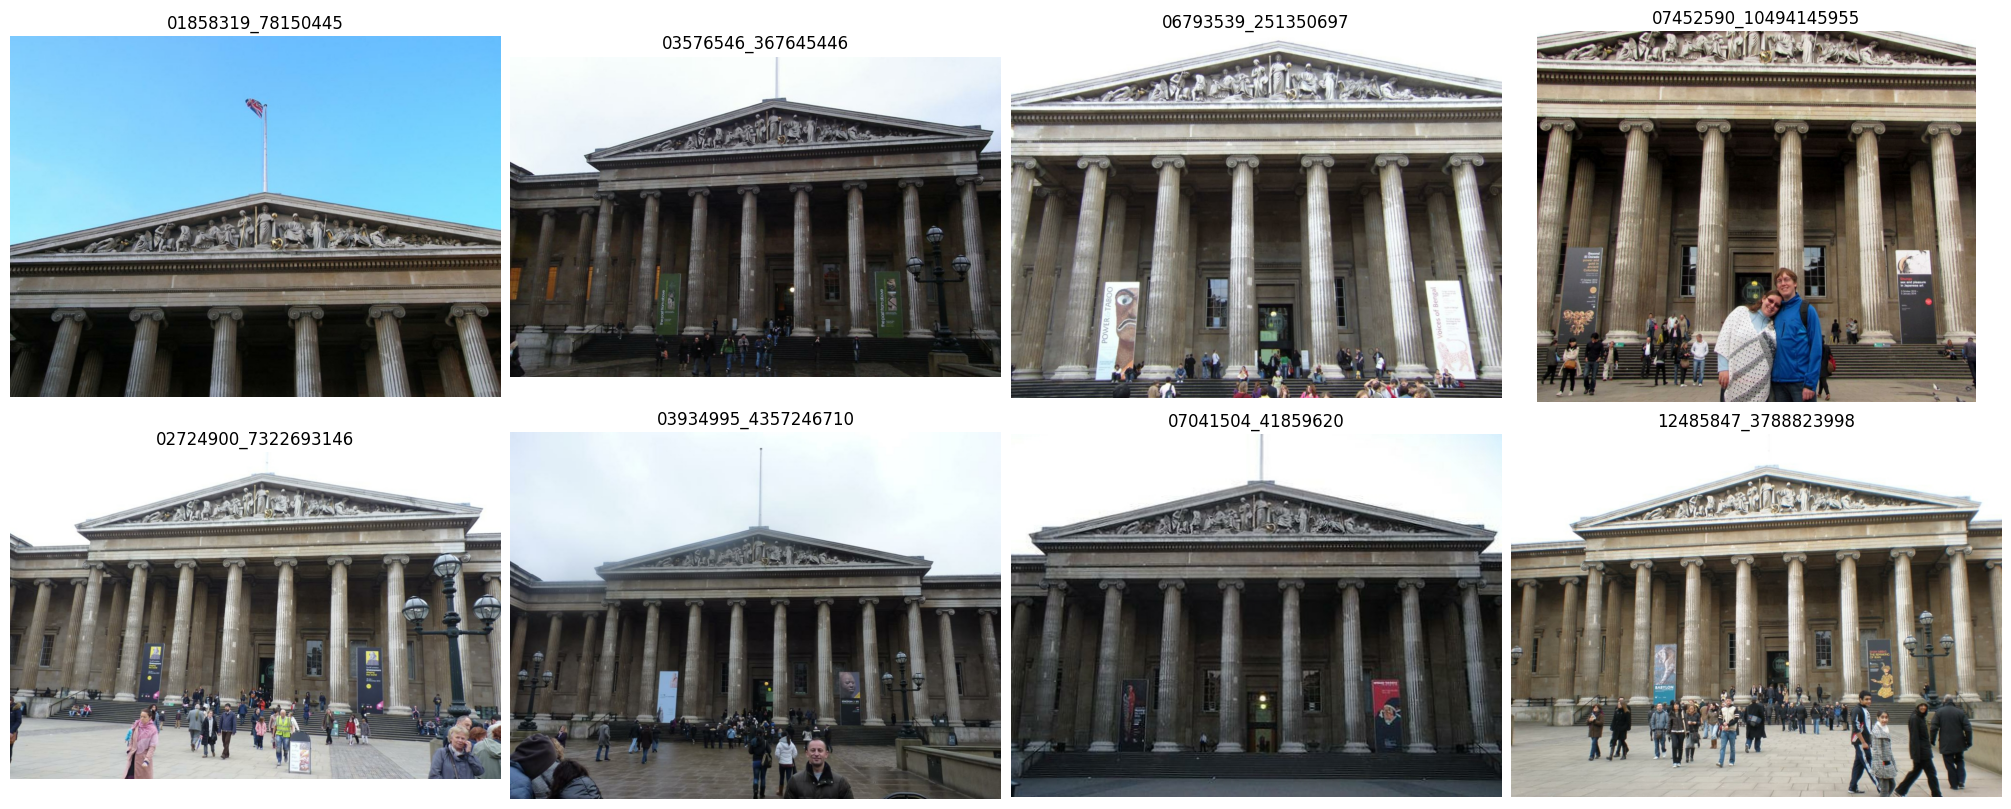

In [61]:
scene = 'british_museum'

images_dict = {}
for filename in glob(f'{data_src}/{scene}/images/*.jpg'):
    cur_id = os.path.basename(os.path.splitext(filename)[0])
    images_dict[cur_id] = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    
print(f'Loaded {len(images_dict)} images.')

num_rows = 2
num_cols = 4
f, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8), constrained_layout=True)
for i, key in enumerate(images_dict):
    if i >= num_rows * num_cols:
        break
    cur_ax = axes[i % num_rows, i // num_rows]
    cur_ax.imshow(images_dict[key])
    cur_ax.set_title(key)
    cur_ax.axis('off')

In [62]:
### KEEP developing the tryout playground

"""
Where one would like to:
1) Specify 2 images
2) Calculates the error between them
3) implementating shit to better calculates whats happening
4) Draw everything that is going on in this playground.
"""


'\nWhere one would like to:\n1) Specify 2 images\n2) Calculates the error between them\n3) implementating shit to better calculates whats happening\n4) Draw everything that is going on in this playground.\n'

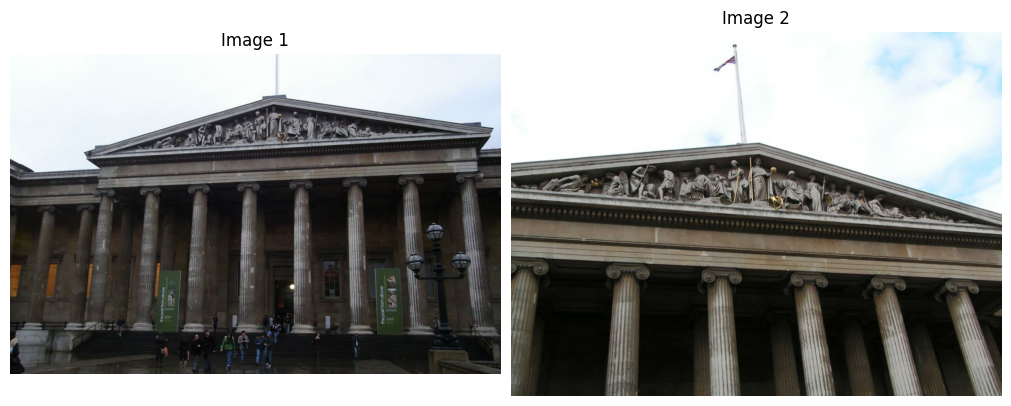

In [77]:
image_1_id = "03576546_367645446"
image_2_id = "92942151_2078102935"

img_1 = cv2.cvtColor(cv2.imread(f'{data_src}/{scene}/images/{image_1_id}.jpg'), cv2.COLOR_BGR2RGB)
img_2 = cv2.cvtColor(cv2.imread(f'{data_src}/{scene}/images/{image_2_id}.jpg'), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 8), constrained_layout=True)
axes[0].imshow(img_1)
axes[0].axis('off')
axes[0].set_title("Image 1")  
axes[1].imshow(img_2)
axes[1].axis('off') 
axes[1].set_title("Image 2")
plt.show()


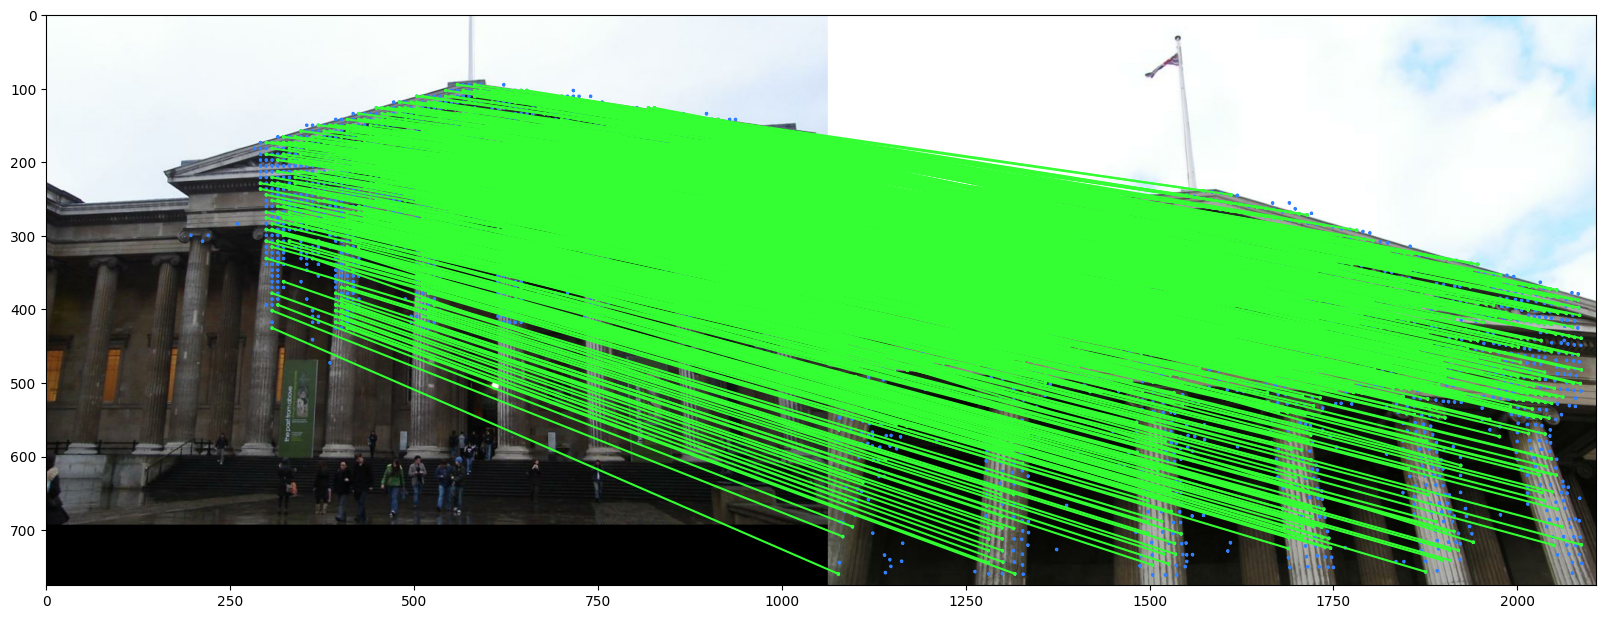

In [78]:
image_1, img1_h_scale, img1_w_scale = get_tensor_from_np(img_1, device, 1080)
image_2, img2_h_scale, img2_w_scale = get_tensor_from_np(img_2, device, 1080)

mkpts0, mkpts1, conf = get_loftr_matches(image_1, image_2, matcher)

# transforming points to original scale
mkpts0[:, 0] /= img1_h_scale
mkpts0[:, 1] /= img1_w_scale
mkpts1[:, 0] /= img2_h_scale
mkpts1[:, 1] /= img2_w_scale

mask = conf > 0.1
mkpts1 = mkpts1[mask].cpu().numpy()
mkpts0 = mkpts0[mask].cpu().numpy()

F, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.2, 0.9999, 100000)

draw_LAF_matches(
            KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1, -1, 2),
                                         torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
                                         torch.ones(mkpts0.shape[0]).view(1, -1, 1)),

            KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1, -1, 2),
                                         torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
                                         torch.ones(mkpts1.shape[0]).view(1, -1, 1)),
            torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
            img_1,
            img_2,
            inliers,
            draw_dict={'inlier_color': (0.2, 1, 0.2),
                       'tentative_color': None,
                       'feature_color': (0.2, 0.5, 1), 'vertical': False})